In [1]:
%pylab inline

import pandas as pd

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
filename,=!ls *.csv
filename

'output_for_Yoav v2a.csv'

In [3]:
df=pd.read_csv(filename)
df.head(2)

,id,unique_key,prep_id,label,coord_x (microns),coord_y (microns),coord_z (microns),polygon_id,volume_id,point_ordering,polygon_ordering
0,247784,MD594_SC_137,MD594,SC,11401.248,4420.108,2740,29649d59a0f6626b36c0b8a46a8fa9c30789c2df,9a661f4f149f6571e0873cf2182d12f5a54a2452,0,0
1,247785,MD594_SC_137,MD594,SC,11323.052,4439.544,2740,29649d59a0f6626b36c0b8a46a8fa9c30789c2df,9a661f4f149f6571e0873cf2182d12f5a54a2452,1,0


In [4]:
df.columns

Index(['id', 'unique_key', 'prep_id', 'label', 'coord_x (microns)',
       'coord_y (microns)', 'coord_z (microns)', 'polygon_id', 'volume_id',
       'point_ordering', 'polygon_ordering'],
      dtype='object')

In [7]:
df=df[['prep_id','label','coord_x (microns)',\
       'coord_y (microns)', 'coord_z (microns)',\
       'point_ordering', 'polygon_ordering']]
df.columns=['prep_id', 'label', 'x', 'y',\
       'z', 'point_ordering', 'polygon_ordering']

In [24]:
# x aand y should be ints like z
df['x']=round(df['x'])
df['y']=round(df['y'])
df.head()

,prep_id,label,x,y,z,point_ordering,polygon_ordering
0,MD594,SC,11401.0,4420.0,2740,0,0
1,MD594,SC,11323.0,4440.0,2740,1,0
2,MD594,SC,11262.0,4443.0,2740,2,0
3,MD594,SC,11232.0,4392.0,2740,3,0
4,MD594,SC,11262.0,4281.0,2740,4,0


In [25]:
prep_id=list(df['prep_id'])
volume_id=list(df['label'])
pairs=list(zip(prep_id,volume_id))
pairs[:5]

from collections import Counter
Counter(pairs)

Counter({('MD594', 'SC'): 21942, ('MD594', 'IC'): 17408})

In [26]:
structures=list(set(pairs))
structures

[('MD594', 'SC'), ('MD594', 'IC')]

In [28]:
sdf=df[df['label']=='IC']
sdf.head(4)

,prep_id,label,x,y,z,point_ordering,polygon_ordering
15,MD594,IC,12331.0,3631.0,2760,0,1
16,MD594,IC,12468.0,3495.0,2760,1,1
17,MD594,IC,12626.0,3444.0,2760,2,1
18,MD594,IC,12666.0,3597.0,2760,3,1


In [29]:
#polygon ordering stuck at 1
Counter(list(sdf['polygon_ordering']))

Counter({1: 17408})

In [30]:
Counter(list(sdf['z']))

Counter({2760: 15,
         2780: 94,
         2800: 98,
         2820: 99,
         2840: 16,
         2860: 104,
         2880: 108,
         2900: 111,
         2920: 115,
         2940: 117,
         2960: 121,
         2980: 123,
         3000: 127,
         3020: 129,
         3040: 19,
         3060: 136,
         3080: 136,
         3100: 137,
         3120: 137,
         3140: 136,
         3160: 136,
         3180: 137,
         3200: 137,
         3220: 137,
         3240: 21,
         3260: 141,
         3280: 138,
         3300: 134,
         3320: 134,
         3340: 132,
         3360: 130,
         3380: 129,
         3400: 127,
         3420: 127,
         3440: 126,
         3460: 125,
         3480: 125,
         3500: 125,
         3520: 125,
         3540: 125,
         3560: 124,
         3580: 124,
         3600: 124,
         3620: 123,
         3640: 123,
         3660: 123,
         3680: 123,
         3700: 123,
         3720: 123,
         3760: 123,
       

In [197]:
Zs=sorted(list(set(sdf['z'])))

In [201]:
%%time
poly={}

for z in Zs:
    poly_df=sdf[sdf['z']==z]
    x=list(poly_df['x'])
    y=list(poly_df['y'])
    x.append(x[0])
    y.append(y[0])
    x=np.array(x,dtype=np.int32)
    y=np.array(y,dtype=np.int32)
    poly[z]=stack([x,y]).transpose()

CPU times: user 44.6 ms, sys: 3.13 ms, total: 47.7 ms
Wall time: 46.1 ms


In [202]:
poly[3640][:5,:]

array([[12653,  4164],
       [12614,  4164],
       [12582,  4157],
       [12551,  4149],
       [12527,  4134]], dtype=int32)

In [206]:
def plot_section(z):
    x=poly[z][:,0]
    y=poly[z][:,1]
    plot(x,y)
    grid()

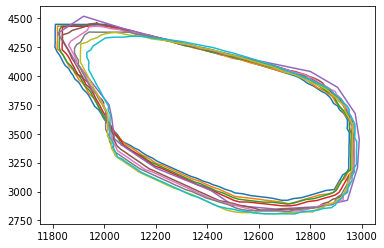

In [210]:
i=20
for i in range(20,30):
    plot_section(Zs[i])


In [217]:
def calc_lengths(P):
    diff=P[1:,:]-P[:-1,:]
    D=sqrt(sum(diff**2,axis=1))
    min_len=np.min(D)
    Length=sum(D)
    return Length,min_len

def refine_boundary(P,step_no=400):

    Length,min_len = calc_lengths(P)

    step=Length/step_no  # step between consecutive points
    if step>min_len/2:
        raise BaseException('Refinement Error step_no=%d needs to be increased to more than %5.0f'\
        %(step_no,2*Length/min_len))
    fine=[]
    start=0   # distance to latest polygon point
    for i in range(P.shape[0]-1):
        a=P[i,:];b=P[i+1,:]
        _dir=b-a
        Len=norm(_dir)
        _dir=_dir/Len
        assert abs(norm(_dir)-1.0)<1e-6, 'norm=%5.2f'%norm(_dir)
        for coeff in arange(start,Len,step):
            fine.append(a+coeff*_dir)
        start=step-(Len-coeff) 
        assert start>=0, 'start=%f'%start
        assert start<=step, 'start=%f'%start

    return stack(fine[:-1])  

In [277]:
i=100
fine1=refine_boundary(poly[Zs[i]],step_no=700)
fine2=refine_boundary(poly[Zs[i+1]],step_no=700)
print(fine1.shape,fine2.shape)

(699, 2) (699, 2)


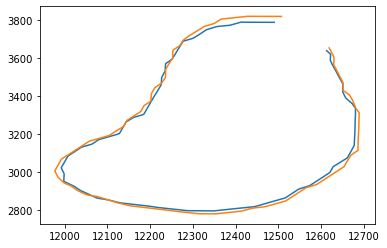

In [278]:
plot(fine1[:-50,0],fine1[:-50,1])
plot(fine2[:-50,0],fine2[:-50,1])

In [279]:
def rotate(fine,i):
    assert i>=0 and i<fine.shape[0], 'i=%d not in range [0,%d]'%(i,fine.shape[0]-1)
    ans=concatenate([fine[i:,:],fine[:i,:]])
    return ans                   

In [280]:
len=fine1.shape[0]
err=[]
for i in range(len):
    sfine2=rotate(fine2,i)
    err.append(sqrt(sum(((fine1-sfine2)**2).flatten())/fine1.shape[0]))

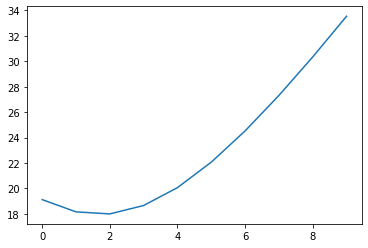

In [281]:
plot(err[:10])

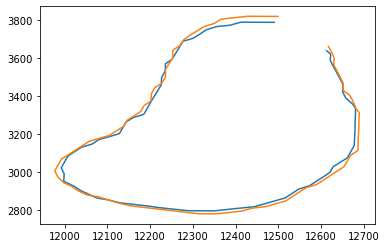

In [282]:
sfine2=rotate(fine2,argmin(err))
plot(fine1[:-50,0],fine1[:-50,1])
plot(sfine2[:-50,0],sfine2[:-50,1])

### What I need to do next
For each point in Dists we need to compute the distance from the last point of P. Normalizing this distance with appropriate element of `D`. This last number is then the coefficient for the vector connecting `P[i,:]` and `P[i+1,:]`

In [58]:
_norm=norm(seg)
_dir = seg/_norm
_norm,_dir

(206.9806754264755, array([-0.98559926, -0.16909791]))

In [59]:
while r<_norm:
    p+=step*_dir
    Points.append(p)
    r+=step


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int32') with casting rule 'same_kind'